In [1]:
import seaborn

In [2]:
import pandas as pd

def get_action_df(raw_df, action):
    return raw_df.loc[raw_df["actionType"] == action].drop("actionType", 1)


def is_filter_player(steam_id, filter_id):
    if steam_id == filter_id:
        return 1
    else:
        return 0
    
def get_dfs(csvpath, dropna=True):
    raw_df = pd.read_csv(csvpath)
    if dropna:
        raw_df = raw_df.dropna()
    
    attack_df = get_action_df(raw_df, "ATTACK")
    move_df = get_action_df(raw_df, "MOVE")
    cast_df = get_action_df(raw_df, "CAST")

    return attack_df, move_df, cast_df

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split


def split_data(df, filterID, test_size=0.01):
    y = df["steamid"].map(lambda steamid: is_filter_player(steamid, filterID))
    
    return train_test_split(df.drop("steamid", 1), y,
                           stratify=y, test_size=test_size, random_state=99)

def fit_model(model, X, y):
    model.fit(X, y)
    
    return model

def get_scores(model, X, y):
    predictions = model.predict(X)
    
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    
    return accuracy, precision, recall

In [73]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def get_action_df(raw_df, action):
    return raw_df.loc[raw_df["actionType"] == action].drop("actionType", 1)


def is_filter_player(steam_id, filter_id):
    if steam_id == filter_id:
        return 1
    else:
        return 0
    
def get_dfs(csvpath, dropna=True):
    raw_df = pd.read_csv(csvpath)
    if dropna:
        raw_df = raw_df.dropna()
    
    attack_df = get_action_df(raw_df, "ATTACK")
    move_df = get_action_df(raw_df, "MOVE")
    cast_df = get_action_df(raw_df, "CAST")

    return attack_df, move_df, cast_df


class Game:

    def __init__(self, csv_file):
        a, m, c = get_dfs(csv_file)

        self.attack_df = a
        self.move_df = m
        self.cast_df = c



class GameClassifier:

    def __init__(self, filter_id, attack_model, move_model, cast_model):
        self.filter_id = filter_id
        self.attack_model = attack_model
        self.move_model = move_model
        self.cast_model = cast_model


    def cross_validate(self, games, ys, splits=3):
        kf = KFold(n_splits=splits)
        for train, test in kf.split(games):
            training_games, testing_games = games[train], games[test]

            for model,train_df,test_df in self.concat_data(training_games, testing_games):
                self.fit(model, train_df)


    def concat_data(self, training_games, testing_games, drop_steamid=False):
        train_attack_df, train_move_df, train_cast_df = self.concat_games(training_games, drop_steamid)
        test_attack_df, test_move_df, test_cast_df = self.concat_games(testing_games, drop_steamid)

        return ((self.attack_model,train_attack_df,test_attack_df),
                (self.move_model,train_move_df,test_move_df),
                (self.cast_model,train_cast_df,test_cast_df))


    def concat_games(self, games, drop_steamid):
        attack_df = pd.concat([game.attack_df for game in games])
        move_df = pd.concat([game.move_df for game in games])
        cast_df = pd.concat([game.cast_df for game in games])

        dfs = (attack_df, move_df, cast_df)
        if drop_steamid:
            return tuple(map(lambda df: df.drop("steamid", 1), dfs))
        else:
            return dfs


    def concat_ys(self, games):
        attack_df, move_df, cast_df = concat_games(games, False)

        return get_y(attack_df), get_y(move_df), get_y(cast_df)


    def get_y(self, df):
        return df["steamid"].map(lambda steamid: is_filter_player(steamid, self.filter_id))

    
    def fit(self, model, df):
        y = df["steamid"].map(lambda steamid: is_filter_player(steamid, self.filter_id))
        #X = df.drop("steamid", 1)
        model.fit(df, y)


    def get_scores(self, model, X, y):
        predictions = model.predict(X)
        return accuracy_score(y, predictions)


    def predict(self, games):
        attack_ys, move_ys, cast_ys = self.concat_ys(games)
        attack_df, move_df, cast_df = self.concat_games(games, True)

        attack_score = self.get_scores(attack_model, attack_df, attack_ys)
        move_score = self.get_scores(move_model, move_df, move_ys)
        cast_score = self.get_scores(cast_model, cast_df, cast_ys)

        if attack_score + move_score + cast_score > 1.5:
            return 1
        else:
            return 0

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def print_scores(model, X_test, y_test, name):
    accuracy, precision, recall = get_scores(model, X_test, y_test)
    print("{} - Accuracy: {}, Precision: {}, Recall: {}".format(name, accuracy, precision, recall)) 

    
def ml(csvpath, filter_id):
    # Create dataframes
    attack_df, move_df, cast_df = get_dfs(csvpath)
    print("Got {} attacks, {} moves, {} casts\n".format(len(attack_df.index), len(move_df.index), len(cast_df.index)))

    models = {}
    
    # Run through learning model
    for name,df in [("ATTACK",attack_df), ("MOVE", move_df), ("CAST", cast_df)]:
        X_train, X_test, y_train, y_test = split_data(df, filter_id, test_size=0.5)
        
        lr = fit_model(LogisticRegression(class_weight={0:.7, 1: 1}), X_train, y_train)
        #rf = fit_model(RandomForestClassifier(), X_train, y_train)
        #tree = fit_model(DecisionTreeClassifier(), X_train, y_train)
        
        models[name] = (lr) #(lr, rf, tree)
        
        print_scores(lr, X_test, y_test, "LR {}".format(name))
        #print_scores(rf, X_test, y_test, "RF {}".format(name))
        #print_scores(tree, X_test, y_test, "Tree {}".format(name))
        print("----")
    
    return models


In [53]:
# Evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm)
    fig = plt.figure(figsize=(10,7))
    sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")

def evaluate(csvpath):
    attack_df, move_df, cast_df = get_dfs(csvpath)

    for name,eval_df in [("ATTACK", attack_df),("MOVE", move_df), ("CAST", cast_df)]:
        _, X_test, _, y_test = split_data(eval_df, filterID, test_size=0.99)
        
        model = models[name]
        #for model in models[name]:
        print_scores(model, X_test, y_test, name)
        pred = model.predict(X_test)
        cm = confusion_matrix(y_test, pred)
        plot_confusion_matrix(cm)

In [54]:
# Spectre
#filterID = 76561198051158462
#ml("/cs/scratch/sy35/dota-data/67-mouseaction.csv", filterID)

In [55]:
# Pudge
#Got 19553 attacks, 268340 moves, 3481 casts
filterID = 76561198119286646
models = ml("/cs/scratch/sy35/dota-data/14/14-mouseaction.csv", filterID)

Got 16058 attacks, 214461 moves, 2793 casts

LR ATTACK - Accuracy: 0.8142981691368788, Precision: 0.6623655913978495, Recall: 0.5880668257756563
----
LR MOVE - Accuracy: 0.7617480019770402, Precision: 0.6894892517913681, Recall: 0.7567326596863426
----
LR CAST - Accuracy: 0.7895490336435218, Precision: 0.6776699029126214, Recall: 0.7316561844863732
----


ATTACK - Accuracy: 0.7702635504724018, Precision: 0.7532228360957642, Recall: 0.5549525101763908
MOVE - Accuracy: 0.8028724488119104, Precision: 0.8709480495696234, Recall: 0.7860172993223514
CAST - Accuracy: 0.8433420365535248, Precision: 0.8269230769230769, Recall: 0.7962962962962963


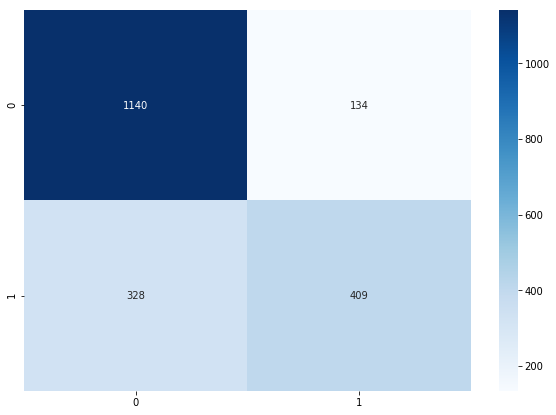

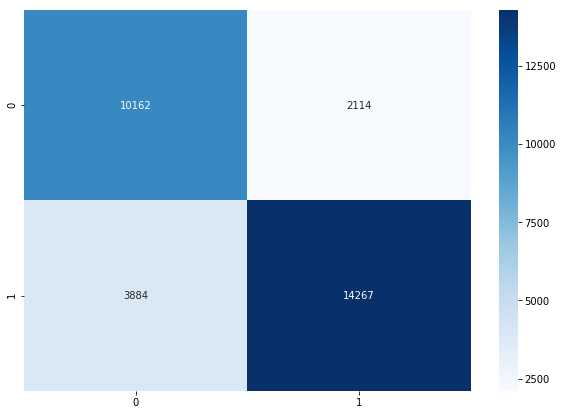

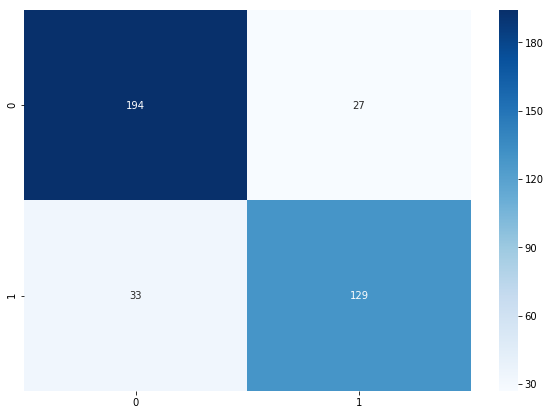

In [56]:
evaluate("/cs/scratch/sy35/dota-data/14/evaluation.csv")